# FLIGHT OPERATIONS ANALYSIS & DIFFICULTY SCORING 

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 




### PHASE 1: BUSINESS UNDERSTANDING

GOAL: 

Analyze flight operations to identify complexity drivers and develop a
"Flight Difficulty Score" for proactive resource management.


DELIVERABLES:
1. Exploratory Data Analysis (EDA).
2. A daily Flight Difficulty Score.
3. Actionable operational insights.



### PHASE 2: DATA UNDERSTANDING

In [11]:


# PHASE 2: DATA UNDERSTANDING


try:
    print("\n[Phase 2/6] Loading datasets...")
    flight_df = pd.read_csv('Flight Level Data.csv')
    pnr_flight_df = pd.read_csv('PNR+Flight+Level+Data.csv')
    pnr_remark_df = pd.read_csv('PNR Remark Level Data.csv')
    bag_df = pd.read_csv('Bag+Level+Data.csv')
    airports_df = pd.read_csv('Airports Data.csv')
    print("All data files loaded successfully.")
except FileNotFoundError as e:
    print(f"\nError loading files: {e}.")
    print("Please ensure all 5 CSV files are in the same directory as this script.")
    exit()



[Phase 2/6] Loading datasets...
All data files loaded successfully.


### PHASE 3: DATA PREPARATION


In [12]:



# PHASE 3: DATA PREPARATION


print("\n[Phase 3/6] Preparing and engineering features from data...")

# Convert date/time columns
for df_loop in [flight_df, pnr_flight_df, bag_df]:
    for col in df_loop.columns:
        if 'date' in col:
            df_loop[col] = pd.to_datetime(df_loop[col], errors='coerce')
for col in ['scheduled_departure_datetime_local', 'scheduled_arrival_datetime_local', 'actual_departure_datetime_local', 'actual_arrival_datetime_local']:
    flight_df[col] = pd.to_datetime(flight_df[col], errors='coerce')

# Define a unique flight identifier
flight_identifier = ['company_id', 'flight_number', 'scheduled_departure_date_local']

# a) Engineer core flight features
flight_df['departure_delay'] = (flight_df['actual_departure_datetime_local'] - flight_df['scheduled_departure_datetime_local']).dt.total_seconds() / 60
flight_df['ground_time_pressure'] = flight_df['minimum_turn_minutes'] - flight_df['scheduled_ground_time_minutes']

# b) Aggregate PNR, SSR, and Bag data
pnr_agg = pnr_flight_df.groupby(flight_identifier).agg(
    total_pax=('total_pax', 'sum'),
    children_count=('is_child', lambda x: (x == 'Y').sum()),
    lap_child_count=('lap_child_count', 'sum')
).reset_index()

pnr_remark_df['pnr_creation_date'] = pd.to_datetime(pnr_remark_df['pnr_creation_date'])
pnr_flight_df_dates = pnr_flight_df[flight_identifier + ['record_locator', 'pnr_creation_date']].drop_duplicates()
ssr_merged = pd.merge(pnr_remark_df, pnr_flight_df_dates, on=['record_locator', 'pnr_creation_date', 'flight_number'])
ssr_agg = ssr_merged.groupby(flight_identifier).size().reset_index(name='ssr_count')

bag_counts = bag_df.groupby(flight_identifier + ['bag_type']).size().unstack(fill_value=0).reset_index()
if 'Origin' not in bag_counts.columns: bag_counts['Origin'] = 0
if 'Transfer' not in bag_counts.columns: bag_counts['Transfer'] = 0
bag_counts.rename(columns={'Origin': 'checked_bags', 'Transfer': 'transfer_bags'}, inplace=True)

# c) Merge into a master DataFrame
df = pd.merge(flight_df, pnr_agg, on=flight_identifier, how='left')
df = pd.merge(df, ssr_agg, on=flight_identifier, how='left')
df = pd.merge(df, bag_counts, on=flight_identifier, how='left')

# d) Handle nulls and create final features
for col in ['total_pax', 'children_count', 'lap_child_count', 'ssr_count', 'checked_bags', 'transfer_bags']:
    df[col].fillna(0, inplace=True)
df.dropna(subset=['departure_delay', 'total_seats'], inplace=True)
df = df[df['total_seats'] > 0]
df['load_factor'] = df['total_pax'] / df['total_seats']
df.loc[df['load_factor'] > 1, 'load_factor'] = 1
df['transfer_bag_ratio'] = df['transfer_bags'] / (df['checked_bags'] + df['transfer_bags']).replace(0, 1)

print("Preprocessing complete. Master analysis DataFrame created.")



[Phase 3/6] Preparing and engineering features from data...
Preprocessing complete. Master analysis DataFrame created.


C:\Users\Ribhav\AppData\Local\Temp\ipykernel_24776\133530180.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace=True)


### PHASE 4: MODELING (EDA & Difficulty Score)


[Phase 4/6] Answering EDA Questions and Building Difficulty Score...

--- EDA Insights
1. Average Delay: 47.06 minutes for late flights.
2. Flights with Tight Schedules: 652 flights.

Using PCA and K-Means to determine difficulty classes...
PCA Explained Variance Ratio: PC1=0.61, PC2=0.23
PCA + K-Means classification and daily ranking complete.


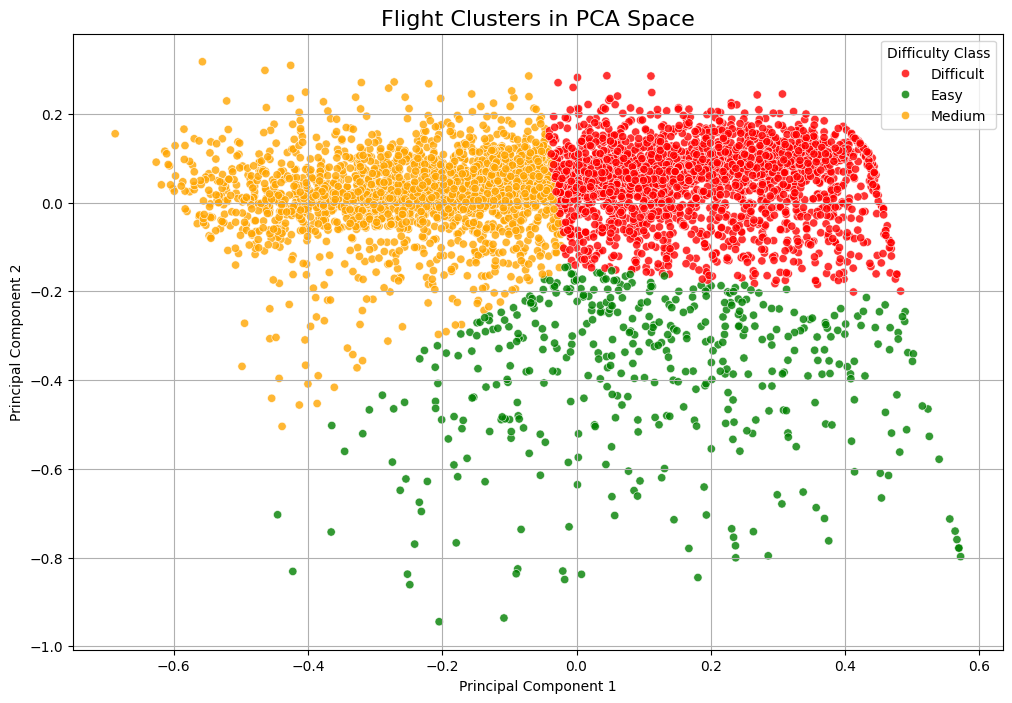

In [13]:



# PHASE 4: MODELING (EDA & Difficulty Score)


print("\n[Phase 4/6] Answering EDA Questions and Building Difficulty Score...")

# DELIVERABLE 1: EXPLORATORY DATA ANALYSIS
# (Answers are printed for context but not the main focus of this script version)
print("\n--- EDA Insights")
delayed_flights = df[df['departure_delay'] > 0]
print(f"1. Average Delay: {delayed_flights['departure_delay'].mean():.2f} minutes for late flights.")
tight_schedule_flights = df[df['ground_time_pressure'] >= 0]
print(f"2. Flights with Tight Schedules: {len(tight_schedule_flights)} flights.")

# DELIVERABLE 2: FLIGHT DIFFICULTY SCORE DEVELOPMENT
difficulty_features = {
    'load_factor': 1,
    'ssr_count': 1.5,
    'transfer_bag_ratio': 1.2,
    'children_count': 0.8,
    'ground_time_pressure': 1.5
}
scaler = MinMaxScaler()
df_normalized = df.copy()
# Create a separate dataframe for PCA features
pca_features = df_normalized[list(difficulty_features.keys())].values
pca_features_scaled = scaler.fit_transform(pca_features)

# MODIFIED: Use PCA + K-Means Clustering for Classification
print("\nUsing PCA and K-Means to determine difficulty classes...")

# 1. Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(pca_features_scaled)
df['PC1'] = principal_components[:, 0]
df['PC2'] = principal_components[:, 1]
print(f"PCA Explained Variance Ratio: PC1={pca.explained_variance_ratio_[0]:.2f}, PC2={pca.explained_variance_ratio_[1]:.2f}")

# 2. Apply K-Means on the Principal Components
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(df[['PC1', 'PC2']])

# 3. Label Clusters
# We still need a single metric to rank the clusters. A simple sum of the PCs works,
# or we can use the original difficulty score for interpretability. Let's use the latter.
df['difficulty_score'] = 0
for feature, weight in difficulty_features.items():
    df['difficulty_score'] += df_normalized[feature] * weight

cluster_means = df.groupby('cluster')['difficulty_score'].mean().sort_values()
difficulty_mapping = {
    cluster_means.index[0]: 'Easy',
    cluster_means.index[1]: 'Medium',
    cluster_means.index[2]: 'Difficult'
}
df['difficulty_class'] = df['cluster'].map(difficulty_mapping)

# Rank flights within each day
df['daily_rank'] = df.groupby('scheduled_departure_date_local')['difficulty_score'].rank(method='first', ascending=False)
print("PCA + K-Means classification and daily ranking complete.")

# NEW VISUALIZATION: Show PCA Cluster Separation
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df.sample(5000, random_state=42), # Use a sample for clarity
                x='PC1',
                y='PC2',
                hue='difficulty_class',
                palette={'Easy': 'green', 'Medium': 'orange', 'Difficult': 'red'},
                alpha=0.8)
plt.title('Flight Clusters in PCA Space', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Difficulty Class')
plt.grid(True)
plt.show()



### PHASE 5: EVALUATION


[Phase 5/6] Evaluating the Difficulty Score...


C:\Users\Ribhav\AppData\Local\Temp\ipykernel_24776\2143762648.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='difficulty_class', y='departure_delay',


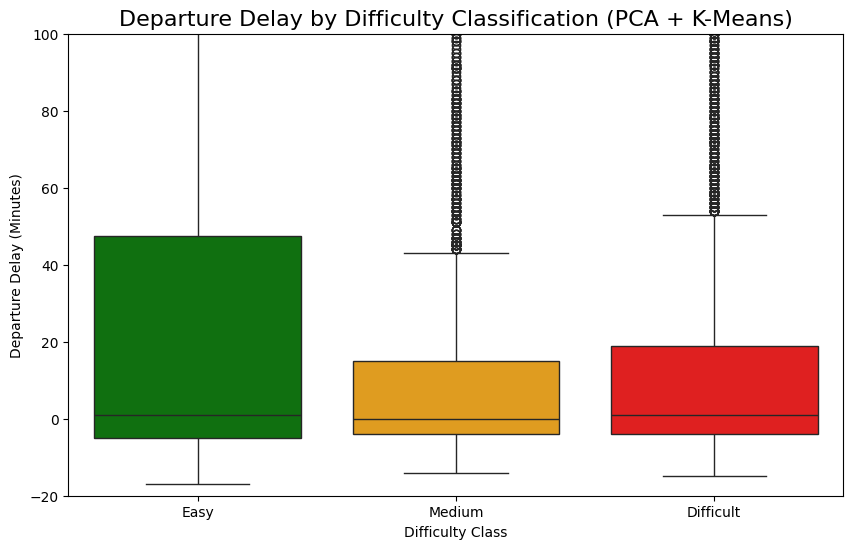

In [14]:


# PHASE 5: EVALUATION


print("\n[Phase 5/6] Evaluating the Difficulty Score...")
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='difficulty_class', y='departure_delay',
            order=['Easy', 'Medium', 'Difficult'],
            palette={'Easy': 'green', 'Medium': 'orange', 'Difficult': 'red'})
plt.title('Departure Delay by Difficulty Classification (PCA + K-Means)', fontsize=16)
plt.xlabel('Difficulty Class')
plt.ylabel('Departure Delay (Minutes)')
plt.ylim(-20, 100)
plt.show()




Generating daily distribution of difficulty classes...


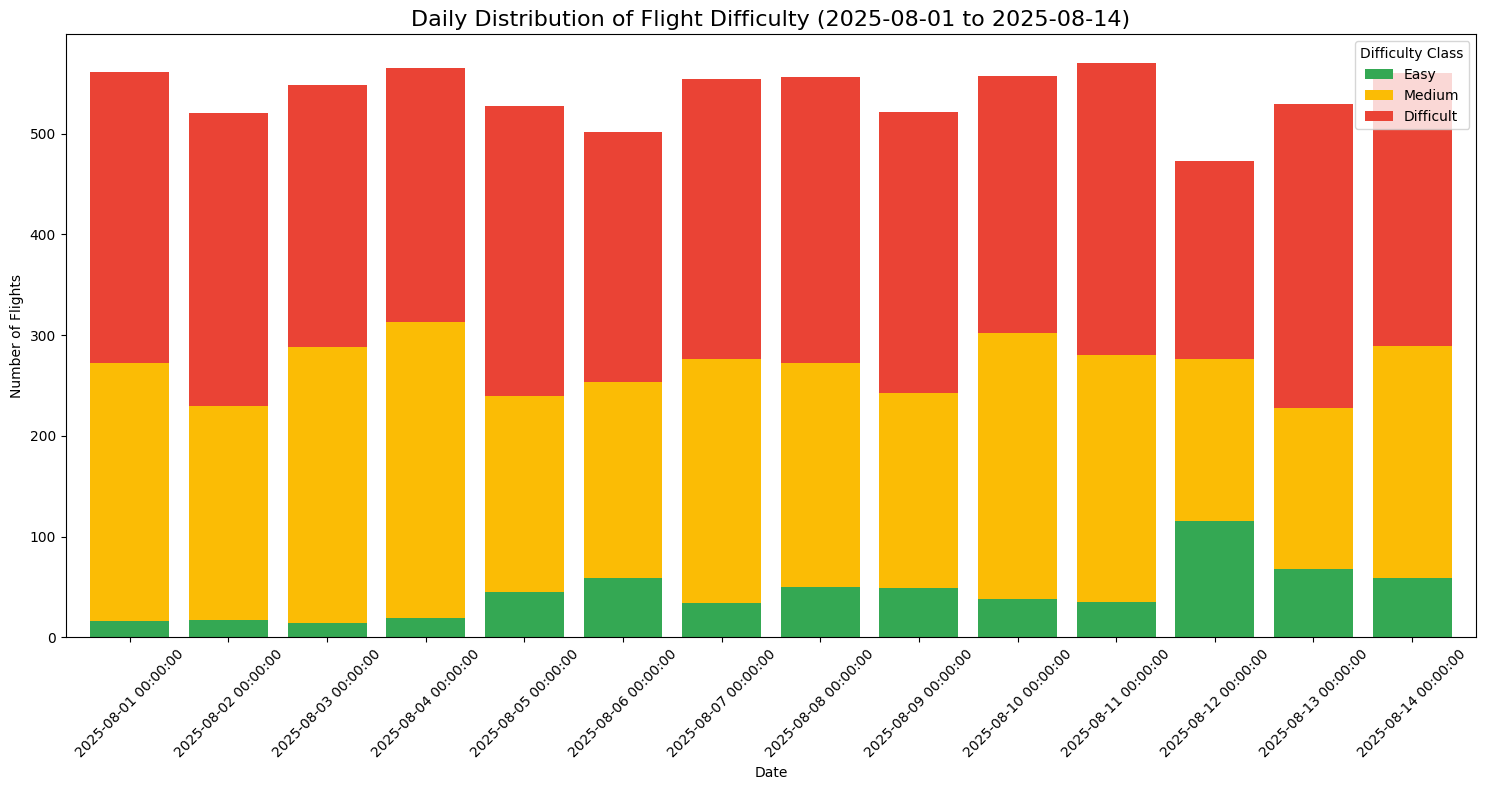

In [15]:
# Visualization of Daily Difficulty Distribution
import pandas as pd
print("\nGenerating daily distribution of difficulty classes...")

# Create a summary table counting the number of flights in each class for each day
daily_distribution = pd.crosstab(df['scheduled_departure_date_local'], df['difficulty_class'])

# Reorder columns for a logical stack (Easy -> Medium -> Difficult)
if 'Easy' in daily_distribution.columns and 'Medium' in daily_distribution.columns and 'Difficult' in daily_distribution.columns:
    daily_distribution = daily_distribution[['Easy', 'Medium', 'Difficult']]

# To make the graph readable, let's select a 2-week window from the data
start_date = daily_distribution.index.min()
end_date = start_date + pd.Timedelta(days=13)
sample_period = daily_distribution.loc[start_date:end_date]

# Create the stacked bar chart
sample_period.plot(kind='bar', 
                   stacked=True, 
                   figsize=(15, 8),
                   color={'Easy': '#34A853', 'Medium': '#FBBC05', 'Difficult': '#EA4335'},
                   width=0.8)

plt.title(f'Daily Distribution of Flight Difficulty ({start_date.strftime("%Y-%m-%d")} to {end_date.strftime("%Y-%m-%d")})', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Number of Flights')
plt.xticks(rotation=45)
plt.legend(title='Difficulty Class')
plt.tight_layout()
plt.show()


### PHASE 6: DEPLOYMENT (INSIGHTS)

In [16]:


# PHASE 6: DEPLOYMENT (INSIGHTS)


print("\n[Phase 6/6] Generating Final Insights and Recommendations...")
print("\n--- Operational Insights")

# a) Summarize difficult destinations
difficult_flights = df[df['difficulty_class'] == 'Difficult']
top_difficult_destinations = difficult_flights['scheduled_arrival_station_code'].value_counts().nlargest(5)
print("1. Top 5 Most Consistently Difficult Destinations (based on PCA clustering):")
print(top_difficult_destinations)

# b) Analyze common drivers
top_dest_drivers = difficult_flights[difficult_flights['scheduled_arrival_station_code'].isin(top_difficult_destinations.index)]
driver_analysis = top_dest_drivers.groupby('scheduled_arrival_station_code')[list(difficulty_features.keys())].mean()
print("\n2. Common Drivers for Top Difficult Destinations (Average Values):")
print(driver_analysis.round(2))

# c) Recommendations
print("\n3. Recommendations for Better Operational Efficiency:")
print("   - Proactive Resource Allocation: Use the daily 'Difficult' classification from the clustering model to pre-allocate staff for flights to top difficult destinations.")
print("   - Targeted SSR Support: High SSR counts remain a key complexity driver. An alert system for the gate manager on these flights could streamline boarding.")
print("   - Baggage Hotspot Management: Focus on optimizing baggage handling for flights with a high transfer bag ratio, especially at hub airports.")
print("   - Gate and Turnaround Strategy: Assign flights with high ground time pressure to efficient gates and ensure turnaround crews are pre-briefed.")




[Phase 6/6] Generating Final Insights and Recommendations...

--- Operational Insights
1. Top 5 Most Consistently Difficult Destinations (based on PCA clustering):
scheduled_arrival_station_code
STL    115
DTW     85
GRR     85
CMH     80
MSN     79
Name: count, dtype: int64

2. Common Drivers for Top Difficult Destinations (Average Values):
                                load_factor  ssr_count  transfer_bag_ratio  \
scheduled_arrival_station_code                                               
CMH                                    0.95       1.88                0.75   
DTW                                    0.95       1.81                0.78   
GRR                                    0.95       1.60                0.89   
MSN                                    0.95       1.23                0.90   
STL                                    0.99       1.50                0.82   

                                children_count  ground_time_pressure  
scheduled_arrival_station_code       